In [214]:
import numpy as np
import librosa.feature as ft
import wave
import struct
import matplotlib.pyplot as plt
import librosa
import time
import librosa.display
import tpt_tools

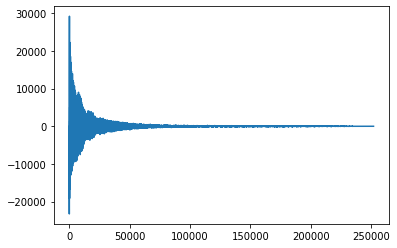

In [215]:
audioFile = './Gtr-ord-D5-pp-1c.wav'
wavefile = wave.open(audioFile, 'rb')
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data, dtype = 'float')
plt.figure()
plt.plot(x)
plt.show()

In [216]:
import IPython.display as ipd
ipd.Audio(audioFile)

In [217]:
def spectral_slope(data, sr, n_fft=2048, hop_length=None, win_length=None, 
                   window='hann', center=True, pad_mode='constant'):

    S, phase = librosa.magphase(librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                             center=center, pad_mode=pad_mode))
    slope = np.zeros((1,S.shape[1]))
    freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    for k in range(S.shape[1]):
        fit = np.polyfit(freq, S[:,k], 1)
        slope[0,k] =fit[0]
    return slope

slope = spectral_slope(x, Fs)

In [221]:
'''
    y = np.ndarray [shape=(…, n)] or None
        audio time series. Multi-channel is supported.
        
    sr = number > 0 [scalar]
        audio sampling rate of y
        
    S = np.ndarray [shape=(…, d, t)] or None
        (optional) spectrogram magnitude
        
    n_fft = int > 0 [scalar]
        FFT window size
        
    hop_length = int > 0 [scalar]
        hop length for STFT. See librosa.stft for details.
        
    win_length = int <= n_fft [scalar]
        Each frame of audio is windowed by window(). The window will be of length win_length and then padded with zeros to match n_fft. If unspecified, defaults to win_length = n_fft.
    
    freq = None or np.ndarray [shape=(d,) or shape=(…, d, t)]
        Center frequencies for spectrogram bins. If None, then FFT bin center frequencies are used. Otherwise, it can be a single array of d center frequencies, or a matrix of center frequencies as constructed by librosa.reassigned_spectrogram
        
    window = string, tuple, number, function, or np.ndarray [shape=(n_fft,)]
            a window specification (string, tuple, or number); see scipy.signal.get_window
            a window function, such as scipy.signal.windows.hann
            a vector or array of length n_fft

    center =boolean
            If True, the signal y is padded so that frame t is centered at y[t * hop_length].
            If False, then frame t begins at y[t * hop_length]

    pad_mode = string
        If center=True, the padding mode to use at the edges of the signal. By default, STFT uses zero padding.
        
    
    centroid = None or np.ndarray [shape=(…, 1, t)]
        pre-computed centroid frequencies
        
    norm = bool
        Normalize per-frame spectral energy (sum to one)
        
    p = float > 0
        Power to raise deviation from spectral centroid.
    
    fmin = float > 0
    Frequency cutoff for the first bin [0, fmin] Subsequent bins will cover [fmin, 2*fmin]`, `[2*fmin, 4*fmin], etc.
    
    n_bands = int > 1
    number of frequency bands
    
    quantile = float in (0, 1)
    quantile for determining peaks and valleys
    
    linear = bool
    If True, return the linear difference of magnitudes: peaks - valleys. If False, return the logarithmic difference: log(peaks) - log(valleys).
    
    amin = float > 0 [scalar]
    minimum threshold for S (=added noise floor for numerical stability)
    
    power = float > 0 [scalar]
    Exponent for the magnitude spectrogram. e.g., 1 for energy, 2 for power, etc. Power spectrogram is usually used for computing spectral flatness.
    
    roll_percent  =float [0 < roll_percent < 1]
    Roll-off percentage.


'''



def compute_features(data, sr, S=None, n_fft=2048, frame_length=2048, hop_length=512, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85):
    
    
    cent = librosa.feature.spectral_centroid(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, freq = freq,
                                             win_length=win_length, window=window, center=center, pad_mode=pad_mode)
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                 center=center, pad_mode=pad_mode, freq=freq, centroid=centroid, norm=norm, p=p)
    contrast = librosa.feature.spectral_contrast(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, freq=freq, fmin=fmin, n_bands=n_bands, quantile=quantile, linear=linear)
    
    flatness = librosa.feature.spectral_flatness(y=data, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, amin=amin, power=power)
    
    rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                center=center, pad_mode=pad_mode, freq=freq, roll_percent=roll_percent)
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length, center=center)
    
    rms = librosa.feature.rms(y=data, S=S, frame_length=frame_length, hop_length=hop_length, center=center, pad_mode=pad_mode)
    
    slope = spectral_slope(data, sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, 
                   window=window, center=center, pad_mode=pad_mode)
    
    dict_features = {}
    dict_features['spectral_centroid'] = cent
    dict_features['spectral_bandwidth'] = spec_bw
    dict_features['spectral_contrast'] = contrast
    dict_features['spectral_flatness'] = flatness
    dict_features['spectral_rolloff'] = rolloff
    dict_features['zero_crossing_rate'] = zcr
    dict_features['rms'] = rms
    dict_features['spectral_slope'] = slope
    
    return dict_features
        

In [222]:
dict_features = compute_features(x, sr=Fs, S=None, n_fft=2048, hop_length=512, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85)

In [223]:
print(dict_features.keys())

dict_keys(['spectral_centroid', 'spectral_bandwidth', 'spectral_contrast', 'spectral_flatness', 'spectral_rolloff', 'zero_crossing_rate', 'rms', 'spectral_slope'])
